In [243]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset
import ignite
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import keras
import string
import math
from torch.autograd import Variable
pd.set_option("display.max_columns", 101)
pd.set_option("display.max_rows", 101)
np.random.seed(123)
torch.manual_seed(123)
#https://www.analyticsvidhya.com/blog/2019/01/guide-pytorch-neural-networks-case-studies/
from sklearn.metrics import accuracy_score
from sklearn import linear_model, metrics, model_selection, ensemble
from sklearn.linear_model import LinearRegression
from keras.models import Sequential
from keras.layers import Dense
import glob
import os
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle

In [5]:
#Get Data
trainingDataPath = r'../Data/Play By Play/2016/Training' # use your path
allTrainingFiles = glob.glob(os.path.join(trainingDataPath, "*.csv"))

testDataPath = r'../Data/Play By Play/2016/Testing' # use your path
allTestingFiles = glob.glob(os.path.join(testDataPath, "*.csv"))

In [8]:
initialDataSet = pd.concat((pd.read_csv(f) for f in allTrainingFiles))
testingDataSet = pd.concat((pd.read_csv(f) for f in allTestingFiles))

offense_stats = pd.read_csv('../Data/Stats/Offense Stats 2016.csv')
defensive_stats = pd.read_csv('../Data/Stats/Defense Stats 2016.csv')

initialDataSet

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description
0,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,0,127,Michigan State,MSU,252,BYU,BYU,0,0,1,15:00,2016-10-09T02:42:58Z,Kickoff,1,10,35,23,77,"Kevin Cronin kickoff for 65 yds , Garrett Juer..."
1,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,1,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Pass Reception,1,10,77,5,72,Taysom Hill pass complete to Nick Kurtz for 5 ...
2,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,2,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Rush,2,5,72,9,63,Jamaal Williams run for 9 yds to the BYU 37 fo...
3,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,3,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Rush,1,10,63,-1,64,Jamaal Williams run for a loss of 1 yard to th...
4,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,4,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Penalty,2,11,64,15,49,"HILL, Taysom pass incomplete to KURTZ, Nick, Q..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13543,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,21,13,2377,McNeese,MCNS,309,Louisiana,ULL,30,15,4,0:23,2016-09-11T10:10:33Z,Pass Incompletion,1,3,3,0,3,James Tabary pass incomplete to Kylon Highshaw...
13544,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,21,14,2377,McNeese,MCNS,309,Louisiana,ULL,30,22,4,0:12,2016-09-11T09:26:34Z,Rushing Touchdown,2,0,3,3,0,"Dylan Long run for 3 yds for a TD, (Trent Manu..."
13545,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,22,0,2377,McNeese,MCNS,309,Louisiana,ULL,30,22,4,0:12,2016-09-11T10:11:49Z,Kickoff,1,0,65,0,55,Gunnar Raborn on-side kick recovered by UL LAF...
13546,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,22,1,309,Louisiana,ULL,2377,McNeese,MCNS,30,22,4,0:12,2016-09-11T10:15:22Z,Rush,1,10,55,-6,49,TEAM run for a loss of 6 yards to the LaLaf 49


In [9]:
#Combine DataSets
statsJoin = initialDataSet.join(offense_stats.set_index('School'), on='offenseTeam', rsuffix='_offense_stats')
statsJoin = statsJoin.join(defensive_stats.set_index('School'), on='defenseTeam', rsuffix='_defense_stats')

validateStatsJoin = validationDataSet.join(offense_stats.set_index('School'), on='offenseTeam', rsuffix='_offense_stats')
validateStatsJoin = validateStatsJoin.join(defensive_stats.set_index('School'), on='defenseTeam', rsuffix='_defense_stats')

statsJoin

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description,Rk,G,Pts,Passing Completion,Pass Attemps,completion percentage,passing yards,Passing Touchdowns,Rush Attempts,Rushing yards,rush average,Rush Touchdowns,Total Offense Plays,Total yards,total yards per play,First down by pass,First down by rush,Number of Penalties,Penalty yards,Rk_defense_stats,Points Allowed,opponent completions,opponent attempts,opponent completion percentage,opponent passing yards,opponent passing touchdowns,opponent rush attempts,opponent rush yards,opponent average rush,opponent rush touchdowns,total opponent plays,total opponent yards,opponent total yards per play,opponent pass first downs,opponent rush first downs
0,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,0,127,Michigan State,MSU,252,BYU,BYU,0,0,1,15:00,2016-10-09T02:42:58Z,Kickoff,1,10,35,23,77,"Kevin Cronin kickoff for 65 yds , Garrett Juer...",104.0,12.0,24.1,17.6,30.8,57.0,222.3,1.6,39.3,172.7,4.4,1.2,70.1,395.0,5.6,10.4,9.1,6.4,60.3,14.0,19.5,20.8,33.0,63.2,252.2,1.3,33.1,114.4,3.5,1.1,66.1,366.5,5.5,11.0,6.0
1,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,1,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Pass Reception,1,10,77,5,72,Taysom Hill pass complete to Nick Kurtz for 5 ...,62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7
2,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,2,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Rush,2,5,72,9,63,Jamaal Williams run for 9 yds to the BYU 37 fo...,62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7
3,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,3,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Rush,1,10,63,-1,64,Jamaal Williams run for a loss of 1 yard to th...,62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7
4,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,4,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Penalty,2,11,64,15,49,"HILL, Taysom pass incomplete to KURTZ, Nick, Q...",62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13543,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,21,13,2377,McNeese,MCNS,309,Louisiana,ULL,30,15,4,0:23,2016-09-11T10:10:33Z,Pass Incompletion,1,3,3,0,3,James Tabary pass incomplete to Kylon Highshaw...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,25.3,20.8,33.8,61.7,249.9,1.4,37.6,129.6,3.4,1.4,71.4,379.5,5.3,12.0,7.2
13544,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,21,14,2377,McNeese,MCNS,309,Louisiana,ULL,30,22,4,0:12,2016-09-11T09:26:34Z,Rushing Touchdown,2,0,3,3,0,"Dylan Long run for 3 yds for a TD, (Trent Manu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,25.3,20.8,33.8,61.7,249.9,1.4,37.6,129.6,3.4,1.4,71.4,379.5,5.3,12.0,7.2
13545,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,22,0,2377,McNeese,MCNS,309,Louisiana,ULL,30,22,4,0:12,2016-09-11T10:11:49Z,Kickoff,1,0,65,0,55,Gunnar Raborn on-side kick recovered by UL LAF...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

In [11]:
def getWinner(gameId, df):
    final = df.query('gameId == @gameId').iloc[[-1]]
    if(int(final.homeScore) > int(final.awayScore)):
        return 1
    else:
        return 0
    
for index,row in statsJoin.iterrows():
    statsJoin.at[index,'winner'] = getWinner(row['gameId'], statsJoin)

statsJoin

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description,Rk,G,Pts,Passing Completion,Pass Attemps,completion percentage,passing yards,Passing Touchdowns,Rush Attempts,Rushing yards,rush average,Rush Touchdowns,Total Offense Plays,Total yards,total yards per play,First down by pass,First down by rush,Number of Penalties,Penalty yards,Rk_defense_stats,Points Allowed,opponent completions,opponent attempts,opponent completion percentage,opponent passing yards,opponent passing touchdowns,opponent rush attempts,opponent rush yards,opponent average rush,opponent rush touchdowns,total opponent plays,total opponent yards,opponent total yards per play,opponent pass first downs,opponent rush first downs,winner
0,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,0,127,Michigan State,MSU,252,BYU,BYU,0,0,1,15:00,2016-10-09T02:42:58Z,Kickoff,1,10,35,23,77,"Kevin Cronin kickoff for 65 yds , Garrett Juer...",104.0,12.0,24.1,17.6,30.8,57.0,222.3,1.6,39.3,172.7,4.4,1.2,70.1,395.0,5.6,10.4,9.1,6.4,60.3,14.0,19.5,20.8,33.0,63.2,252.2,1.3,33.1,114.4,3.5,1.1,66.1,366.5,5.5,11.0,6.0,1
1,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,1,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Pass Reception,1,10,77,5,72,Taysom Hill pass complete to Nick Kurtz for 5 ...,62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7,1
2,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,2,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Rush,2,5,72,9,63,Jamaal Williams run for 9 yds to the BYU 37 fo...,62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7,1
3,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,3,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Rush,1,10,63,-1,64,Jamaal Williams run for a loss of 1 yard to th...,62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7,1
4,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,4,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Penalty,2,11,64,15,49,"HILL, Taysom pass incomplete to KURTZ, Nick, Q...",62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13543,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,21,13,2377,McNeese,MCNS,309,Louisiana,ULL,30,15,4,0:23,2016-09-11T10:10:33Z,Pass Incompletion,1,3,3,0,3,James Tabary pass incomplete to Kylon Highshaw...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,25.3,20.8,33.8,61.7,249.9,1.4,37.6,129.6,3.4,1.4,71.4,379.5,5.3,12.0,7.2,1
13544,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,21,14,2377,McNeese,MCNS,309,Louisiana,ULL,30,22,4,0:12,2016-09-11T09:26:34Z,Rushing Touchdown,2,0,3,3,0,"Dylan Long run for 3 yds for a TD, (Trent Manu...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,46.0,25.3,20.8,33.8,61.7,249.9,1.4,37.6,129.6,3.4,1.4,71.4,379.5,5.3,12.0,7.2,1
13545,400869812,2016,2,309,Louisiana,ULL,2377,McNeese,MCNS,22,0,2377,McNeese,MCNS,309,Louisiana,ULL,30,22,4,0:12,2016-09-11T10:11:49Z,Kickoff,1,0,65,0,55,Gunnar Raborn on-side kick recovered by UL LAF...,NaN,NaN,NaN,NaN,NaN,Na

In [43]:
statsJoin = statsJoin.dropna()
statsJoin

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description,Rk,G,Pts,Passing Completion,Pass Attemps,completion percentage,passing yards,Passing Touchdowns,Rush Attempts,Rushing yards,rush average,Rush Touchdowns,Total Offense Plays,Total yards,total yards per play,First down by pass,First down by rush,Number of Penalties,Penalty yards,Rk_defense_stats,Points Allowed,opponent completions,opponent attempts,opponent completion percentage,opponent passing yards,opponent passing touchdowns,opponent rush attempts,opponent rush yards,opponent average rush,opponent rush touchdowns,total opponent plays,total opponent yards,opponent total yards per play,opponent pass first downs,opponent rush first downs,winner
0,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,0,127,Michigan State,MSU,252,BYU,BYU,0,0,1,15:00,2016-10-09T02:42:58Z,Kickoff,1,10,35,23,77,"Kevin Cronin kickoff for 65 yds , Garrett Juer...",104.0,12.0,24.1,17.6,30.8,57.0,222.3,1.6,39.3,172.7,4.4,1.2,70.1,395.0,5.6,10.4,9.1,6.4,60.3,14.0,19.5,20.8,33.0,63.2,252.2,1.3,33.1,114.4,3.5,1.1,66.1,366.5,5.5,11.0,6.0,home
1,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,1,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Pass Reception,1,10,77,5,72,Taysom Hill pass complete to Nick Kurtz for 5 ...,62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7,home
2,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,2,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Rush,2,5,72,9,63,Jamaal Williams run for 9 yds to the BYU 37 fo...,62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7,home
3,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,3,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Rush,1,10,63,-1,64,Jamaal Williams run for a loss of 1 yard to th...,62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7,home
4,400868927,2016,6,127,Michigan State,MSU,252,BYU,BYU,0,4,252,BYU,BYU,127,Michigan State,MSU,0,0,1,15:00,2016-10-09T02:42:58Z,Penalty,2,11,64,15,49,"HILL, Taysom pass incomplete to KURTZ, Nick, Q...",62.0,13.0,29.5,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,60.2,61.0,27.8,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7,home
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11224,400869511,2016,2,2509,Purdue,PUR,2132,Cincinnati,CIN,23,7,2509,Purdue,PUR,2132,Cincinnati,CIN,20,38,4,1:04,2016-09-11T02:24:21Z,Pass Incompletion,2,1,79,0,79,David Blough pass incomplete to David Yancey,101.0,12.0,24.6,26.0,46.4,56.0,294.9,2.1,30.0,96.3,3.2,1.0,76.4,391.3,5.1,12.7,6.5,4.3,37.3,55.0,26.9,19.9,32.4,61.4,233.3,1.5,46.8,189.8,4.1,1.4,79.2,423.0,5.3,11.3,11.1,away
11225,400869511,2016,2,2509,Purdue,PUR,2132,Cincinnati,CIN,23,8,2509,Purdue,PUR,2132,Cincinnati,CIN,20,38,4,1:04,2016-09-11T02:24:21Z,Pass Interception Return,3,1,79,0,80,"David Blough pass intercepted, touchback. Alex...",101.0,12.0,24.6,26.0,46.4,56.0,294.9,2.1,30.0,96.3,3.2,1.0,76.4,391.3,5.1,12.7,6.5,4.3,37.3,55.0,26.9,19.9,32.4,61.4,233.3,1.5,46.8,189.8,4.1,1.4,79.2,423.0,5.3,11.3,11.1,away
11226,400869511,2016,2,2509,Purdue,PUR,2132,Cincinnati,CIN,24,0,2132,Cincinnati,CIN,2509,Purdue,PUR,20,38,4,0:51,2016-09-11T02:26:50Z,Rush,1,10,80,-2,82,TEAM run for a

In [22]:
def getQuarterPlays(quarter, df):
    final = df.query('quarter == @quarter')
    return final

fourthQuarter = getQuarterPlays(4, statsJoin).dropna()
thirdQuarter = getQuarterPlays(3, statsJoin).dropna()
secondQuarter = getQuarterPlays(2, statsJoin).dropna()
firstQuarter = getQuarterPlays(1, statsJoin).dropna()

In [286]:


totalFeatures = thirdQuarter[['homeScore', 'awayScore', 
       'down', 'distance',
       'Passing Completion', 'Pass Attemps',
       'completion percentage', 'passing yards', 'Passing Touchdowns',
       'Rush Attempts', 'Rushing yards', 'rush average', 'Rush Touchdowns',
       'Total Offense Plays', 'Total yards', 'total yards per play',
       'First down by pass', 'First down by rush', 'Number of Penalties',
       'opponent completions', 'opponent attempts',
       'opponent completion percentage', 'opponent passing yards',
       'opponent passing touchdowns', 'opponent rush attempts',
       'opponent rush yards', 'opponent average rush',
       'opponent rush touchdowns', 'total opponent plays',
       'total opponent yards', 'opponent total yards per play',
       'opponent pass first downs', 'opponent rush first downs']]

homeTeamWins = thirdQuarter['winner']

totalFeatures.columns = totalFeatures.columns.str.replace(' ', '')



print('# of home team wins = {}'.format(homeTeamWins.tolist().count(1)))
print('# of home team losses = {}'.format(homeTeamWins.tolist().count(0)))
print('# of wins and losses = {}'.format(len(homeTeamWins)))

totalFeatures

# of home team wins = 6722
# of home team losses = 1075
# of wins and losses = 7797


,homeScore,awayScore,down,distance,PassingCompletion,PassAttemps,completionpercentage,passingyards,PassingTouchdowns,RushAttempts,Rushingyards,rushaverage,RushTouchdowns,TotalOffensePlays,Totalyards,totalyardsperplay,Firstdownbypass,Firstdownbyrush,NumberofPenalties,opponentcompletions,opponentattempts,opponentcompletionpercentage,opponentpassingyards,opponentpassingtouchdowns,opponentrushattempts,opponentrushyards,opponentaveragerush,opponentrushtouchdowns,totalopponentplays,totalopponentyards,opponenttotalyardsperplay,opponentpassfirstdowns,opponentrushfirstdowns
85,7,3,1,0,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,16.5,27.7,59.6,206.2,1.6,38.3,158.7,4.1,1.8,66.0,364.8,5.5,9.0,7.7
86,7,3,1,10,17.6,30.8,57.0,222.3,1.6,39.3,172.7,4.4,1.2,70.1,395.0,5.6,10.4,9.1,6.4,20.8,33.0,63.2,252.2,1.3,33.1,114.4,3.5,1.1,66.1,366.5,5.5,11.0,6.0
87,7,3,1,10,17.6,30.8,57.0,222.3,1.6,39.3,172.7,4.4,1.2,70.1,395.0,5.6,10.4,9.1,6.4,20.8,33.0,63.2,252.2,1.3,33.1,114.4,3.5,1.1,66.1,366.5,5.5,11.0,6.0
88,7,3,2,8,17.6,30.8,57.0,222.3,1.6,39.3,172.7,4.4,1.2,70.1,395.0,5.6,10.4,9.1,6.4,20.8,33.0,63.2,252.2,1.3,33.1,114.4,3.5,1.1,66.1,366.5,5.5,11.0,6.0
89,7,3,3,6,17.6,30.8,57.0,222.3,1.6,39.3,172.7,4.4,1.2,70.1,395.0,5.6,10.4,9.1,6.4,20.8,33.0,63.2,252.2,1.3,33.1,114.4,3.5,1.1,66.1,366.5,5.5,11.0,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11166,7,24,3,5,21.6,37.8,57.2,255.9,1.6,33.0,118.3,3.6,0.7,70.8,374.3,5.3,11.9,6.3,4.6,15.6,26.3,59.4,207.4,1.8,45.3,238.5,5.3,2.9,71.6,445.9,6.2,9.3,11.3
11167,7,24,4,5,21.6,37.8,57.2,255.9,1.6,33.0,118.3,3.6,0.7,70.8,374.3,5.3,11.9,6.3,4.6,15.6,26.3,59.4,207.4,1.8,45.3,238.5,5.3,2.9,71.6,445.9,6.2,9.3,11.3
11168,7,24,1,10,26.0,46.4,56.0,294.9,2.1,30.0,96.3,3.2,1.0,76.4,391.3,5.1,12.7,6.5,4.3,19.9,32.4,61.4,233.3,1.5,46.8,189.8,4.1,1.4,79.2,423.0,5.3,11.3,11.1
11169,7,24,2,6,26.0,46.4,56.0,294.9,2.1,30.0,96.3,3.2,1.0,76.4,391.3,5.1,12.7,6.5,4.3,19.9,32.4,61.4,233.3,1.5,46.8,189.8,4.1,1.4,79.2,423.0,5.3,11.3,11.1


In [287]:
#XGBoost

seed = 7
test_size = 0.25
X_train, X_test, y_train, y_test = train_test_split(totalFeatures, homeTeamWins, test_size=test_size, random_state=seed)

X_train.columns

Index(['homeScore', 'awayScore', 'down', 'distance', 'PassingCompletion',
       'PassAttemps', 'completionpercentage', 'passingyards',
       'PassingTouchdowns', 'RushAttempts', 'Rushingyards', 'rushaverage',
       'RushTouchdowns', 'TotalOffensePlays', 'Totalyards',
       'totalyardsperplay', 'Firstdownbypass', 'Firstdownbyrush',
       'NumberofPenalties', 'opponentcompletions', 'opponentattempts',
       'opponentcompletionpercentage', 'opponentpassingyards',
       'opponentpassingtouchdowns', 'opponentrushattempts',
       'opponentrushyards', 'opponentaveragerush', 'opponentrushtouchdowns',
       'totalopponentplays', 'totalopponentyards', 'opponenttotalyardsperplay',
       'opponentpassfirstdowns', 'opponentrushfirstdowns'],
      dtype='object')

In [288]:
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
print(model)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


In [265]:
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
print(y_test)

1229     1
1024     0
710      1
9240     1
7653     1
        ..
8296     0
1056     0
307      1
2173     1
10012    1
Name: winner, Length: 1950, dtype: object


In [267]:
# evaluate predictions
accuracy = accuracy_score(y_test.tolist(), predictions)
print("Third Quarter AUC: " + str(roc_auc_score(y_test.astype('bool'), y_pred.astype('bool'))))
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Third Quarter AUC: 0.8683276412294945
Accuracy: 96.21%


In [198]:
print(model.feature_importances_)

[0.03130833 0.02948109 0.         0.00390423 0.0161593  0.02233564
 0.0406261  0.02976216 0.02314371 0.02889846 0.05549403 0.02959789
 0.0332582  0.03321673 0.03011863 0.04142129 0.02420079 0.04779664
 0.03832678 0.02633197 0.02861593 0.04127731 0.02964254 0.03489929
 0.03399156 0.01250606 0.03806224 0.04292345 0.03896271 0.0167737
 0.03849164 0.02978828 0.02868335]


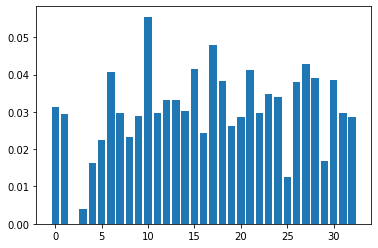

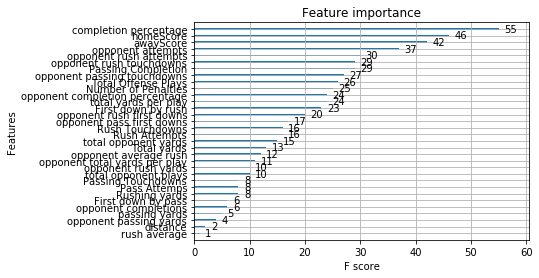

In [199]:
# plot feature importance manually
from numpy import loadtxt
from xgboost import XGBClassifier
from matplotlib import pyplot
from xgboost import plot_importance

# load data
pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

plot_importance(model)
pyplot.show()

In [200]:
#Random Forest

from sklearn.ensemble import RandomForestRegressor
# try with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 33)
# Train the model on training data
rf.fit(X_train, y_train);

Mean Absolute Error: 0.01 degrees.


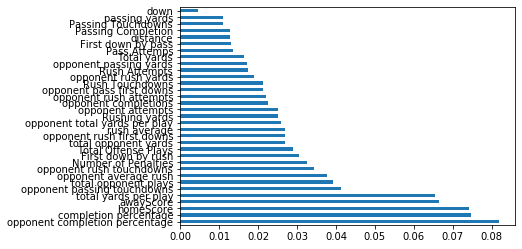

In [201]:
# Use the forest's predict method on the test data
predictions = rf.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

feat_importances = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_importances.nlargest(X_train.columns.size).plot(kind='barh')

In [202]:
#GasussinNB
from sklearn.naive_bayes import GaussianNB

# Initialize our classifier
gnb = GaussianNB()
y_train1=y_train.astype('int')

# Train our classifier
model = gnb.fit(X_train, y_train1)

In [203]:
# Make predictions
preds = gnb.predict(X_test)
print(preds)

y_test1 = y_test.astype('int')
print(accuracy_score(y_test1, preds))

[1 0 1 ... 1 1 1]
0.7764102564102564


In [290]:
#Fourth Quarter

totalFeatures = fourthQuarter[['homeScore', 'awayScore', 
       'down', 'distance',
       'Passing Completion', 'Pass Attemps',
       'completion percentage', 'passing yards', 'Passing Touchdowns',
       'Rush Attempts', 'Rushing yards', 'rush average', 'Rush Touchdowns',
       'Total Offense Plays', 'Total yards', 'total yards per play',
       'First down by pass', 'First down by rush', 'Number of Penalties',
       'opponent completions', 'opponent attempts',
       'opponent completion percentage', 'opponent passing yards',
       'opponent passing touchdowns', 'opponent rush attempts',
       'opponent rush yards', 'opponent average rush',
       'opponent rush touchdowns', 'total opponent plays',
       'total opponent yards', 'opponent total yards per play',
       'opponent pass first downs', 'opponent rush first downs']]

homeTeamWins = fourthQuarter['winner']

totalFeatures.columns = totalFeatures.columns.str.replace(' ', '')

print('# of home team wins = {}'.format(homeTeamWins.tolist().count(1)))
print('# of home team losses = {}'.format(homeTeamWins.tolist().count(0)))
print('# of wins and losses = {}'.format(len(homeTeamWins)))

totalFeatures.columns

# of home team wins = 6914
# of home team losses = 1191
# of wins and losses = 8105


Index(['homeScore', 'awayScore', 'down', 'distance', 'PassingCompletion',
       'PassAttemps', 'completionpercentage', 'passingyards',
       'PassingTouchdowns', 'RushAttempts', 'Rushingyards', 'rushaverage',
       'RushTouchdowns', 'TotalOffensePlays', 'Totalyards',
       'totalyardsperplay', 'Firstdownbypass', 'Firstdownbyrush',
       'NumberofPenalties', 'opponentcompletions', 'opponentattempts',
       'opponentcompletionpercentage', 'opponentpassingyards',
       'opponentpassingtouchdowns', 'opponentrushattempts',
       'opponentrushyards', 'opponentaveragerush', 'opponentrushtouchdowns',
       'totalopponentplays', 'totalopponentyards', 'opponenttotalyardsperplay',
       'opponentpassfirstdowns', 'opponentrushfirstdowns'],
      dtype='object')

In [291]:
#XGBoost

seed = 7
test_size = 0.25
fourthFeatures_train, fourthFeatures_test, fourthWins_train, fourthWins_test = train_test_split(totalFeatures, homeTeamWins, test_size=test_size, random_state=seed)

fourthFeatures_train

,homeScore,awayScore,down,distance,PassingCompletion,PassAttemps,completionpercentage,passingyards,PassingTouchdowns,RushAttempts,Rushingyards,rushaverage,RushTouchdowns,TotalOffensePlays,Totalyards,totalyardsperplay,Firstdownbypass,Firstdownbyrush,NumberofPenalties,opponentcompletions,opponentattempts,opponentcompletionpercentage,opponentpassingyards,opponentpassingtouchdowns,opponentrushattempts,opponentrushyards,opponentaveragerush,opponentrushtouchdowns,totalopponentplays,totalopponentyards,opponenttotalyardsperplay,opponentpassfirstdowns,opponentrushfirstdowns
9013,21,33,3,6,20.2,35.1,57.7,273.8,1.6,41.1,152.2,3.7,1.4,76.2,426.0,5.6,11.7,8.1,6.1,18.5,32.2,57.7,228.2,1.2,37.3,142.4,3.8,1.5,69.5,370.5,5.3,9.9,8.2
567,35,32,1,10,18.8,31.5,59.8,197.9,1.2,41.8,201.2,4.8,2.2,73.3,399.2,5.4,10.0,10.8,6.4,20.8,36.8,56.7,257.7,1.6,39.8,168.2,4.2,1.1,76.5,425.9,5.6,11.1,9.1
3894,17,38,1,10,16.7,27.7,60.3,244.5,2.2,41.5,218.0,5.2,2.3,69.2,462.5,6.7,10.0,11.1,6.0,17.2,30.3,56.8,249.5,1.6,38.4,203.6,5.3,2.4,68.6,453.1,6.6,10.8,8.6
2800,38,7,2,5,6.4,12.2,52.2,129.2,0.7,47.0,258.1,5.5,2.6,59.2,387.2,6.5,4.4,12.3,4.4,20.8,34.1,61.2,244.6,1.5,35.0,163.5,4.7,1.1,69.1,408.2,5.9,10.6,8.3
2223,21,70,2,8,21.4,33.3,64.4,265.3,2.3,41.1,226.4,5.5,2.4,74.3,491.7,6.6,11.2,10.2,8.3,18.4,32.1,57.2,182.9,0.9,36.7,133.9,3.6,1.1,68.8,316.9,4.6,8.5,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11491,14,17,0,10,6.4,12.2,52.2,129.2,0.7,47.0,258.1,5.5,2.6,59.2,387.2,6.5,4.4,12.3,4.4,16.4,29.3,55.9,205.6,2.2,32.3,108.6,3.4,1.2,61.6,314.2,5.1,8.2,5.2
6212,43,27,0,24,22.0,36.5,60.3,241.8,2.3,33.0,108.2,3.3,1.0,69.5,350.0,5.0,10.4,7.1,7.5,26.9,42.2,63.8,333.2,2.2,33.5,119.6,3.6,2.2,75.8,452.8,6.0,14.8,6.7
3147,31,24,1,10,18.4,31.9,57.7,206.2,0.8,34.1,170.8,5.0,2.1,66.0,377.0,5.7,8.8,7.7,7.2,14.3,24.3,58.9,205.6,1.4,44.3,214.1,4.8,2.5,68.6,419.7,6.1,9.3,10.1
8362,45,40,4,12,20.8,29.5,70.6,318.0,3.3,44.0,236.8,5.4,2.3,73.5,554.8,7.5,13.5,10.5,5.1,20.5,33.8,60.7,258.5,1.8,45.7,190.3,4.2,1.9,79.4,448.8,5.7,10.7,10.3


In [292]:
# fit model no training data
fourthModel = XGBClassifier()
fourthModel.fit(fourthFeatures_train, fourthWins_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [207]:
# make predictions for test data
fourth_pred = fourthModel.predict(fourthFeatures_test)
fourthPredictions = [round(value) for value in fourth_pred]
print(y_test)

1229     1
1024     0
710      1
9240     1
7653     1
        ..
8296     0
1056     0
307      1
2173     1
10012    1
Name: winner, Length: 1950, dtype: object


Accuracy: 96.15%


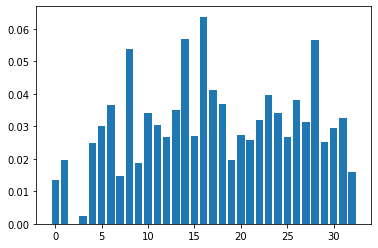

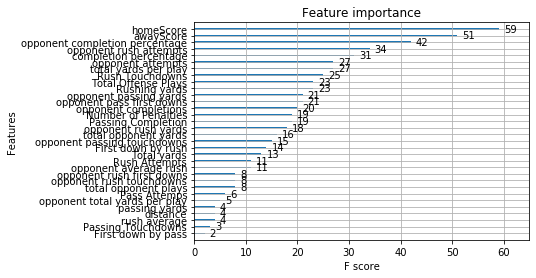

In [208]:
# evaluate predictions
accuracy = accuracy_score(fourthWins_test.tolist(), fourthPredictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


# load data
pyplot.bar(range(len(fourthModel.feature_importances_)), fourthModel.feature_importances_)
pyplot.show()

plot_importance(fourthModel)
pyplot.show()

In [209]:
#Random Forest

# try with 1000 decision trees
fourthRf = RandomForestRegressor(n_estimators = 1000, random_state = 33)
# Train the model on training data
fourthRf.fit(fourthFeatures_train, fourthWins_train);

Mean Absolute Error: 0.01 degrees.


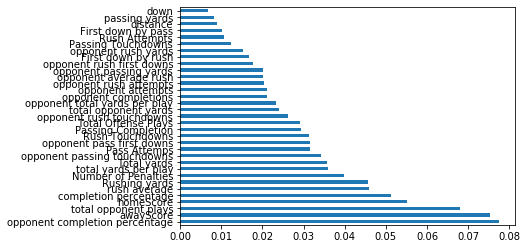

In [210]:
# Use the forest's predict method on the test data
predictions = fourthRf.predict(fourthFeatures_test)
# Calculate the absolute errors
errors = abs(predictions - fourthWins_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

feat_importances = pd.Series(fourthRf.feature_importances_, index=fourthFeatures_train.columns)
feat_importances.nlargest(fourthFeatures_train.columns.size).plot(kind='barh')

In [211]:
#GasussinNB

# Initialize our classifier
fourthGnb = GaussianNB()
fourthWins_train1=fourthWins_train.astype('int')

# Train our classifier
fourthModel = gnb.fit(fourthFeatures_train, fourthWins_train1)

In [212]:
# Make predictions
preds = fourthModel.predict(fourthFeatures_test)
print(preds)

fourthWins_test1 = fourthWins_test.astype('int')
print(accuracy_score(fourthWins_test1, preds))

[1 1 1 ... 1 0 1]
0.7528367044893932


In [268]:
#Try this against a different year
#Get Data
validationDataPath = r'../Data/Play By Play/2016/Testing' # use your path
allValidationFiles = glob.glob(os.path.join(validationDataPath, "*.csv"))

validationDataSet = pd.concat((pd.read_csv(f) for f in allValidationFiles))

offense_stats = pd.read_csv('../Data/Stats/Offense Stats 2016.csv')
defensive_stats = pd.read_csv('../Data/Stats/Defense Stats 2016.csv')

validationDataSet

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description
0,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,0,251,Texas,TEX,239,Baylor,BAY,0,0,1,15:00,2016-10-30T02:43:26Z,Kickoff,1,10,35,0,75,Mitchell Becker kickoff for 65 yds for a touch...
1,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,1,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:57,2016-10-30T02:44:09Z,Pass Incompletion,1,10,75,0,75,Seth Russell pass incomplete to KD Cannon
2,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,2,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:50,2016-10-30T02:44:47Z,Pass Reception,2,10,75,13,62,Seth Russell pass complete to Sam Tecklenburg ...
3,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,3,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:39,2016-10-30T02:44:58Z,Pass Reception,1,10,62,8,54,Seth Russell pass complete to Ishmael Zamora f...
4,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,4,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:31,2016-10-30T02:45:22Z,Rush,2,2,54,4,50,Shock Linwood run for 4 yds to the 50 yard lin...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11760,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,3,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Rush,1,10,78,5,83,Milton Revell run for 5 yds to the Presb 17
11761,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,4,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Pass Reception,2,5,83,5,88,Cole Garvin pass complete to Maaseiah Francis ...
11762,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,5,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Rush,1,10,88,2,90,Milton Revell run for 2 yds to the Presb 10
11763,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,6,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Rush,2,8,90,2,92,Carlos Robinson II run for 2 yds to the Presb 8


In [269]:
#Combine DataSets
validateStatsJoin = validationDataSet.join(offense_stats.set_index('School'), on='offenseTeam', rsuffix='_offense_stats')
validateStatsJoin = validateStatsJoin.join(defensive_stats.set_index('School'), on='defenseTeam', rsuffix='_defense_stats')

validateStatsJoin

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description,Rk,G,Pts,Passing Completion,Pass Attemps,completion percentage,passing yards,Passing Touchdowns,Rush Attempts,Rushing yards,rush average,Rush Touchdowns,Total Offense Plays,Total yards,total yards per play,First down by pass,First down by rush,Number of Penalties,Penalty yards,Rk_defense_stats,Points Allowed,opponent completions,opponent attempts,opponent completion percentage,opponent passing yards,opponent passing touchdowns,opponent rush attempts,opponent rush yards,opponent average rush,opponent rush touchdowns,total opponent plays,total opponent yards,opponent total yards per play,opponent pass first downs,opponent rush first downs
0,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,0,251,Texas,TEX,239,Baylor,BAY,0,0,1,15:00,2016-10-30T02:43:26Z,Kickoff,1,10,35,0,75,Mitchell Becker kickoff for 65 yds for a touch...,46.0,12.0,31.9,20.1,33.5,60.0,252.0,1.8,49.6,240.2,4.8,2.3,83.1,492.2,5.9,10.2,13.1,7.1,64.1,71.0,29.0,17.4,31.7,54.9,230.2,1.3,47.7,200.7,4.2,2.3,79.4,430.8,5.4,9.8,10.2
1,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,1,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:57,2016-10-30T02:44:09Z,Pass Incompletion,1,10,75,0,75,Seth Russell pass incomplete to KD Cannon,35.0,13.0,34.6,20.7,36.9,56.0,280.9,2.5,48.3,241.8,5.0,1.9,85.2,522.7,6.1,10.8,13.4,9.9,82.2,91.0,31.5,20.5,33.8,60.7,258.5,1.8,45.7,190.3,4.2,1.9,79.4,448.8,5.7,10.7,10.3
2,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,2,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:50,2016-10-30T02:44:47Z,Pass Reception,2,10,75,13,62,Seth Russell pass complete to Sam Tecklenburg ...,35.0,13.0,34.6,20.7,36.9,56.0,280.9,2.5,48.3,241.8,5.0,1.9,85.2,522.7,6.1,10.8,13.4,9.9,82.2,91.0,31.5,20.5,33.8,60.7,258.5,1.8,45.7,190.3,4.2,1.9,79.4,448.8,5.7,10.7,10.3
3,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,3,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:39,2016-10-30T02:44:58Z,Pass Reception,1,10,62,8,54,Seth Russell pass complete to Ishmael Zamora f...,35.0,13.0,34.6,20.7,36.9,56.0,280.9,2.5,48.3,241.8,5.0,1.9,85.2,522.7,6.1,10.8,13.4,9.9,82.2,91.0,31.5,20.5,33.8,60.7,258.5,1.8,45.7,190.3,4.2,1.9,79.4,448.8,5.7,10.7,10.3
4,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,4,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:31,2016-10-30T02:45:22Z,Rush,2,2,54,4,50,Shock Linwood run for 4 yds to the 50 yard lin...,35.0,13.0,34.6,20.7,36.9,56.0,280.9,2.5,48.3,241.8,5.0,1.9,85.2,522.7,6.1,10.8,13.4,9.9,82.2,91.0,31.5,20.5,33.8,60.7,258.5,1.8,45.7,190.3,4.2,1.9,79.4,448.8,5.7,10.7,10.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11760,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,3,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Rush,1,10,78,5,83,Milton Revell run for 5 yds to the Presb 17,92.0,13.0,25.4,17.9,31.9,56.1,243.8,1.2,36.1,145.6,4.0,1.9,68.0,389.4,5.7,10.6,7.7,7.6,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11761,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,4,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Pass Reception,2,5,83,5,88,Cole Garvin pass complete to Maaseiah Francis ...,92.0,13.0,25.4,17.9,31.9,56.1,243.8,1.2,36.1,145.6,4.0,1.9,68.0,389.4,5.7,10.6,7.7,7.6,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11762,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,5,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Rush,1,10,88,2,90,Milton Revell run for 2 yds to the Presb 10,92.0,13.0,25.4,17.9,31.9,56.1,243.8,1.2,36.1,145.6,4.0,1.9,68.0,389.4,5.7,10.6,7.7

In [270]:
for index,row in validateStatsJoin.iterrows():
    validateStatsJoin.at[index,'winner'] = getWinner(row['gameId'], validateStatsJoin)

validateStatsJoin

,gameId,year,week,homeId,homeTeam,homeAbbr,awayId,awayTeam,awayAbbr,driveIndex,playIndex,offenseId,offenseTeam,offenseAbbr,defenseId,defenseTeam,defenseAbbr,homeScore,awayScore,quarter,clock,wallclock,type,down,distance,yardLine,yardsGained,endYardLine,description,Rk,G,Pts,Passing Completion,Pass Attemps,completion percentage,passing yards,Passing Touchdowns,Rush Attempts,Rushing yards,rush average,Rush Touchdowns,Total Offense Plays,Total yards,total yards per play,First down by pass,First down by rush,Number of Penalties,Penalty yards,Rk_defense_stats,Points Allowed,opponent completions,opponent attempts,opponent completion percentage,opponent passing yards,opponent passing touchdowns,opponent rush attempts,opponent rush yards,opponent average rush,opponent rush touchdowns,total opponent plays,total opponent yards,opponent total yards per play,opponent pass first downs,opponent rush first downs,winner
0,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,0,251,Texas,TEX,239,Baylor,BAY,0,0,1,15:00,2016-10-30T02:43:26Z,Kickoff,1,10,35,0,75,Mitchell Becker kickoff for 65 yds for a touch...,46.0,12.0,31.9,20.1,33.5,60.0,252.0,1.8,49.6,240.2,4.8,2.3,83.1,492.2,5.9,10.2,13.1,7.1,64.1,71.0,29.0,17.4,31.7,54.9,230.2,1.3,47.7,200.7,4.2,2.3,79.4,430.8,5.4,9.8,10.2,0.0
1,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,1,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:57,2016-10-30T02:44:09Z,Pass Incompletion,1,10,75,0,75,Seth Russell pass incomplete to KD Cannon,35.0,13.0,34.6,20.7,36.9,56.0,280.9,2.5,48.3,241.8,5.0,1.9,85.2,522.7,6.1,10.8,13.4,9.9,82.2,91.0,31.5,20.5,33.8,60.7,258.5,1.8,45.7,190.3,4.2,1.9,79.4,448.8,5.7,10.7,10.3,0.0
2,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,2,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:50,2016-10-30T02:44:47Z,Pass Reception,2,10,75,13,62,Seth Russell pass complete to Sam Tecklenburg ...,35.0,13.0,34.6,20.7,36.9,56.0,280.9,2.5,48.3,241.8,5.0,1.9,85.2,522.7,6.1,10.8,13.4,9.9,82.2,91.0,31.5,20.5,33.8,60.7,258.5,1.8,45.7,190.3,4.2,1.9,79.4,448.8,5.7,10.7,10.3,0.0
3,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,3,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:39,2016-10-30T02:44:58Z,Pass Reception,1,10,62,8,54,Seth Russell pass complete to Ishmael Zamora f...,35.0,13.0,34.6,20.7,36.9,56.0,280.9,2.5,48.3,241.8,5.0,1.9,85.2,522.7,6.1,10.8,13.4,9.9,82.2,91.0,31.5,20.5,33.8,60.7,258.5,1.8,45.7,190.3,4.2,1.9,79.4,448.8,5.7,10.7,10.3,0.0
4,400868881,2016,9,251,Texas,TEX,239,Baylor,BAY,0,4,239,Baylor,BAY,251,Texas,TEX,0,0,1,14:31,2016-10-30T02:45:22Z,Rush,2,2,54,4,50,Shock Linwood run for 4 yds to the 50 yard lin...,35.0,13.0,34.6,20.7,36.9,56.0,280.9,2.5,48.3,241.8,5.0,1.9,85.2,522.7,6.1,10.8,13.4,9.9,82.2,91.0,31.5,20.5,33.8,60.7,258.5,1.8,45.7,190.3,4.2,1.9,79.4,448.8,5.7,10.7,10.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11760,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,3,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Rush,1,10,78,5,83,Milton Revell run for 5 yds to the Presb 17,92.0,13.0,25.4,17.9,31.9,56.1,243.8,1.2,36.1,145.6,4.0,1.9,68.0,389.4,5.7,10.6,7.7,7.6,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
11761,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,4,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Pass Reception,2,5,83,5,88,Cole Garvin pass complete to Maaseiah Francis ...,92.0,13.0,25.4,17.9,31.9,56.1,243.8,1.2,36.1,145.6,4.0,1.9,68.0,389.4,5.7,10.6,7.7,7.6,65.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
11762,400925661,2016,12,6,South Alabama,USA,2506,Presbyterian,PRE,23,5,6,South Alabama,USA,2506,Presbyterian,PRE,31,7,4,3:24,2016-11-20T11:00:47Z,Rush,1,10,88,2,90,Milton Revell run for 2 yds to the Presb 10,92.0,13.0,25.4,17.9,31.9,56.1,243.8,1.2,36.

In [271]:
validateStatsJoin = validateStatsJoin.dropna()
validateStatsJoin

fourthQuarterValidate = getQuarterPlays(4, validateStatsJoin).dropna()
thirdQuarterValidate = getQuarterPlays(3, validateStatsJoin).dropna()
secondQuarterValidate = getQuarterPlays(2, validateStatsJoin).dropna()
firstQuarterValidate = getQuarterPlays(1, validateStatsJoin).dropna()

In [284]:


validateFeaturesThird = thirdQuarterValidate[['homeScore', 'awayScore', 
       'down', 'distance',
       'Passing Completion', 'Pass Attemps',
       'completion percentage', 'passing yards', 'Passing Touchdowns',
       'Rush Attempts', 'Rushing yards', 'rush average', 'Rush Touchdowns',
       'Total Offense Plays', 'Total yards', 'total yards per play',
       'First down by pass', 'First down by rush', 'Number of Penalties',
       'opponent completions', 'opponent attempts',
       'opponent completion percentage', 'opponent passing yards',
       'opponent passing touchdowns', 'opponent rush attempts',
       'opponent rush yards', 'opponent average rush',
       'opponent rush touchdowns', 'total opponent plays',
       'total opponent yards', 'opponent total yards per play',
       'opponent pass first downs', 'opponent rush first downs']]

validateHomeTeamWinsThird = thirdQuarterValidate['winner']

validateFeaturesFourth = fourthQuarterValidate[['homeScore', 'awayScore', 
       'down', 'distance',
       'Passing Completion', 'Pass Attemps',
       'completion percentage', 'passing yards', 'Passing Touchdowns',
       'Rush Attempts', 'Rushing yards', 'rush average', 'Rush Touchdowns',
       'Total Offense Plays', 'Total yards', 'total yards per play',
       'First down by pass', 'First down by rush', 'Number of Penalties',
       'opponent completions', 'opponent attempts',
       'opponent completion percentage', 'opponent passing yards',
       'opponent passing touchdowns', 'opponent rush attempts',
       'opponent rush yards', 'opponent average rush',
       'opponent rush touchdowns', 'total opponent plays',
       'total opponent yards', 'opponent total yards per play',
       'opponent pass first downs', 'opponent rush first downs']]

validateHomeTeamWinsFourth = fourthQuarterValidate['winner']

validateFeaturesThird.columns = validateFeaturesThird.columns.str.replace(' ', '')
validateFeaturesFourth.columns = validateFeaturesFourth.columns.str.replace(' ', '')

print('third: # of home team wins = {}'.format(validateHomeTeamWinsThird.tolist().count(1)))
print('third: # of home team losses = {}'.format(validateHomeTeamWinsThird.tolist().count(0)))
print('third: # of wins and losses = {}'.format(len(validateHomeTeamWinsThird)))

print('fourth: # of home team wins = {}'.format(validateHomeTeamWinsFourth.tolist().count(1)))
print('fourth: # of home team losses = {}'.format(validateHomeTeamWinsFourth.tolist().count(0)))
print('fourth: # of wins and losses = {}'.format(len(validateHomeTeamWinsFourth)))



third: # of home team wins = 4797
third: # of home team losses = 3161
third: # of wins and losses = 7958
fourth: # of home team wins = 5010
fourth: # of home team losses = 3401
fourth: # of wins and losses = 8411


Third Quarter Accuracy: 61.46%
Third Quarter AUC: 0.5191304448756167
Third Quarter SoftMax: [[0.0370993 0.9629007]]
Fourth Quarter Accuracy: 60.18%
Fourth Quarter AUC: 0.5180793661134068
Fourth Quarter SoftMax: [[0.0370993 0.9629007]]


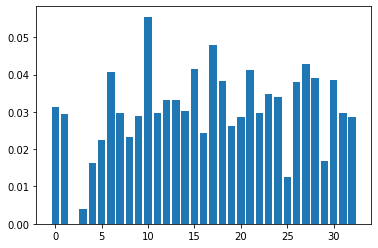

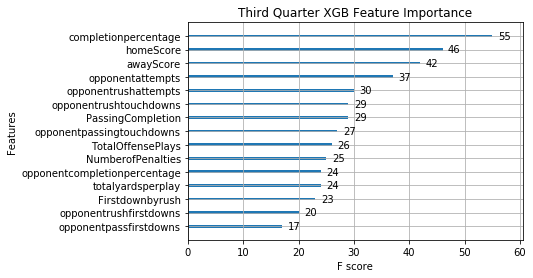

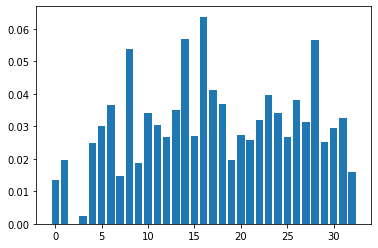

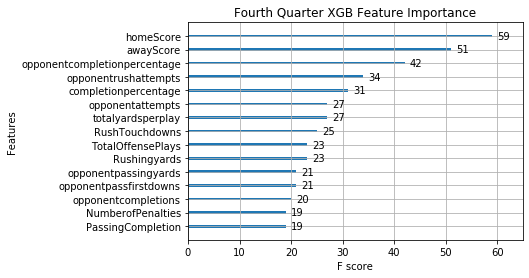

In [320]:
from sklearn import metrics
from xgboost import plot_tree
from sklearn.metrics import roc_auc_score
import shap
import matplotlib.pyplot as plt

shap.initjs()

thirdQuarterXGBModel = 'XGBThirdQuarter.sav'
fourthQuarterXGBModel = 'XGBFourthQuarter.sav'

pickle.dump(model, open(thirdQuarterXGBModel, 'wb'))
pickle.dump(fourthModel, open(fourthQuarterXGBModel, 'wb'))


#XGBBOOST
# make predictions for test data
xgb_third_pred = model.predict(validateFeaturesThird)
predictions_third = [round(value) for value in xgb_third_pred]

# evaluate predictions
accuracy_third = accuracy_score(validateHomeTeamWinsThird.tolist(), predictions_third)
print("Third Quarter Accuracy: %.2f%%" % (accuracy_third * 100.0))
print("Third Quarter AUC: " + str(roc_auc_score(validateHomeTeamWinsThird.astype('bool'), xgb_third_pred.astype('bool'))))
print("Third Quarter SoftMax: " + str(model.predict_proba(validateFeaturesThird[1:2])))

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(validateFeaturesThird)


# make predictions for test data
xgb_fourth_pred = fourthModel.predict(validateFeaturesFourth)
fourthPredictions = [round(value) for value in xgb_fourth_pred]

# evaluate predictions
accuracy_fourth = accuracy_score(validateHomeTeamWinsFourth.tolist(), fourthPredictions)
print("Fourth Quarter Accuracy: %.2f%%" % (accuracy_fourth * 100.0))
print("Fourth Quarter AUC: " + str(roc_auc_score(validateHomeTeamWinsFourth.astype('bool'), xgb_fourth_pred.astype('bool'))))
print("Fourth Quarter SoftMax: " + str(model.predict_proba(validateFeaturesFourth[1:2])))

#shap.force_plot(explainer.expected_value, shap_values[0,:], validateFeaturesThird.iloc[0,:])

#plot_tree(model, num_trees=2, rankdir='LR')
#fig = plt.gcf()
#fig.set_size_inches(150, 100)
#fig.savefig('tree.png')


pyplot.bar(range(len(model.feature_importances_)), model.feature_importances_)
pyplot.show()

plot_importance(model, title='Third Quarter XGB Feature Importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=15)
pyplot.show()

pyplot.bar(range(len(fourthModel.feature_importances_)), fourthModel.feature_importances_)
pyplot.show()

plot_importance(fourthModel,title='Fourth Quarter XGB Feature Importance', xlabel='F score', ylabel='Features', importance_type='weight', max_num_features=15)
pyplot.show()

In [274]:
#RandomForest
# Use the forest's predict method on the test data
predictions_third = rf.predict(validateFeaturesThird)
# Calculate the absolute errors
errors_third = abs(predictions_third - validateHomeTeamWinsThird)
# Print out the mean absolute error (mae)
print('Third Quarter Mean Absolute Error:', round(np.mean(errors_third), 2), 'degrees.')
print("Third Quarter AUC: " + str(roc_auc_score(validateHomeTeamWinsThird.astype('bool'), predictions_third.astype('bool'))))

# Use the forest's predict method on the test data
predictions_fourth = fourthRf.predict(validateFeaturesFourth)
# Calculate the absolute errors
errors_fourth = abs(predictions_fourth - validateHomeTeamWinsFourth)
# Print out the mean absolute error (mae)
print('Fourth Quarter Mean Absolute Error:', round(np.mean(errors_fourth), 2), 'degrees.')
print("Fourth Quarter AUC: " + str(roc_auc_score(validateHomeTeamWinsFourth.astype('bool'), predictions_fourth.astype('bool'))))

Third Quarter Mean Absolute Error: 0.4 degrees.
Third Quarter AUC: 0.5074343562163872
Fourth Quarter Mean Absolute Error: 0.41 degrees.
Fourth Quarter AUC: 0.5


In [275]:
#GasussinNB
# Make predictions
preds_third = gnb.predict(validateFeaturesThird)
validateHomeTeamWinsThird1 = validateHomeTeamWinsThird.astype('int')
print("Third Quarter: " + str(accuracy_score(validateHomeTeamWinsThird1, preds_third)))
print("Third Quarter AUC: " + str(roc_auc_score(validateHomeTeamWinsThird.astype('bool'), preds_third.astype('bool'))))


# Make predictions
preds_fourth = fourthModel.predict(validateFeaturesFourth)
validateHomeTeamWinsFourth1 = validateHomeTeamWinsFourth.astype('int')
print("Fourth Quarter: " + str(accuracy_score(validateHomeTeamWinsFourth1, preds_fourth)))
print("Fourth Quarter AUC: " + str(roc_auc_score(validateHomeTeamWinsFourth1.astype('bool'), preds_fourth.astype('bool'))))

Third Quarter: 0.5593113847700427
Third Quarter AUC: 0.5073623073368445


ValueError: Classification metrics can't handle a mix of binary and unknown targets